# Approximate q-learning

In this notebook you will teach a __tensorflow__ neural network to do Q-learning.

__Frameworks__ - we'll accept this homework in any deep learning framework. This particular notebook was designed for tensorflow, but you will find it easy to adapt it to almost any python-based deep learning framework.

In [1]:
! wget https://github.com/ishalyminov/Practical_RL/raw/coursera/setup_google_colab.py -O setup_google_colab.py
! pip install gym==0.14.0
! apt-get update
! apt-get install -y xvfb
! wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall18/xvfb -O ../xvfb
! apt-get install -y python-opengl ffmpeg
! pip install pyglet==1.2.4

from setup_google_colab import setup_week4
setup_week4()

--2020-04-03 16:05:55--  https://github.com/ishalyminov/Practical_RL/raw/coursera/setup_google_colab.py
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ishalyminov/Practical_RL/coursera/setup_google_colab.py [following]
--2020-04-03 16:05:55--  https://raw.githubusercontent.com/ishalyminov/Practical_RL/coursera/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1744 (1.7K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   1.70K  --.-KB/s    in 0s      

2020-04-03 16:05:55 (313 MB/s) - ‘setup_google_colab.py’ saved [1744/1744]

Hit:1 

In [2]:
#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Starting virtual X frame buffer: Xvfb.


In [0]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

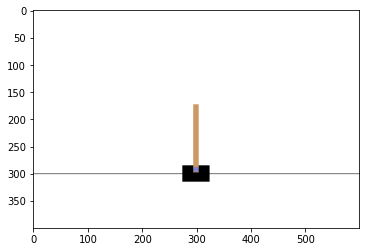

In [4]:
env = gym.make("CartPole-v0").env
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

# Approximate (deep) Q-learning: building the network

To train a neural network policy one must have a neural network policy. Let's build it.


Since we're working with a pre-extracted features (cart positions, angles and velocities), we don't need a complicated network yet. In fact, let's build something like this for starters:

![img](https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/yet_another_week/_resource/qlearning_scheme.png)

For your first run, please only use linear layers (L.Dense) and activations. Stuff like batch normalization or dropout may ruin everything if used haphazardly. 

Also please avoid using nonlinearities like sigmoid & tanh: agent's observations are not normalized so sigmoids may become saturated from init.

Ideally you should start small with maybe 1-2 hidden layers with < 200 neurons and then increase network size if agent doesn't beat the target score.

In [0]:
import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.layers as L

In [0]:
network = tf.keras.models.Sequential()
network.add(L.InputLayer(state_dim))

# let's create a network for approximate q-learning following guidelines above
network.add(L.Dense(64, activation='relu'))
network.add(L.Dense(64, activation='relu'))
network.add(L.Dense(n_actions, activation='linear'))

In [0]:
def get_action(state, epsilon=0):
    """
    sample actions with epsilon-greedy policy
    recap: with p = epsilon pick random action, else pick action with highest Q(s,a)
    """
    if np.random.random() < epsilon:
        return np.random.choice(range(n_actions), size=1)[0]
    q_values = network.predict(state[None])[0]
    best_action = tf.argmax(q_values, axis=-1).numpy()
    return best_action

In [0]:
assert network.output_shape == (None, n_actions), "please make sure your model maps state s -> [Q(s,a0), ..., Q(s, a_last)]"
assert network.layers[-1].activation == keras.activations.linear, "please make sure you predict q-values without nonlinearity"

# test epsilon-greedy exploration
s = env.reset()
assert np.shape(get_action(s)) == (), "please return just one action (integer)"
for eps in [0., 0.1, 0.5, 1.0]:
    state_frequencies = np.bincount([get_action(s, epsilon=eps) for i in range(10000)], minlength=n_actions)
    best_action = state_frequencies.argmax()
    assert abs(state_frequencies[best_action] - 10000 * (1 - eps + eps / n_actions)) < 200
    for other_action in range(n_actions):
        if other_action != best_action:
            assert abs(state_frequencies[other_action] - 10000 * (eps / n_actions)) < 200
    print('e=%.1f tests passed'%eps)

### Q-learning via gradient descent

We shall now train our agent's Q-function by minimizing the TD loss:
$$ L = { 1 \over N} \sum_i (Q_{\theta}(s,a) - [r(s,a) + \gamma \cdot max_{a'} Q_{-}(s', a')]) ^2 $$


Where
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.

The tricky part is with  $Q_{-}(s',a')$. From an engineering standpoint, it's the same as $Q_{\theta}$ - the output of your neural network policy. However, when doing gradient descent, __we won't propagate gradients through it__ to make training more stable (see lectures).

To do so, we shall use `tf.stop_gradient` function which basically says "consider this thing constant when doingbackprop".

### Playing the game

In [0]:
gamma = 0.99
optimizer = tf.keras.optimizers.Adam(1e-4)

def generate_session(t_max=1000, epsilon=0, train=False):
    """play env with approximate q-learning agent and train it at the same time"""
    total_reward = 0
    s = env.reset()
    for t in range(t_max):
        a = get_action(s, epsilon=epsilon)       
        next_s, r, done, _ = env.step(a)
        a_next = get_action(next_s, epsilon=epsilon)

        if train:
          with tf.GradientTape() as tape:
            predicted_qvalues = network(np.array([s]))
            predicted_qvalues_for_actions = tf.reduce_sum(predicted_qvalues * tf.one_hot([a], n_actions), axis=1)
            # compute q-values for all actions in next states
            predicted_next_qvalues = network(np.array([next_s]))
            # compute V*(next_states) using predicted next q-values
            # next_state_values = <YOUR CODE>
            predicted_next_qvalues_for_actions = tf.reduce_sum(predicted_next_qvalues * tf.one_hot([a_next], n_actions), axis=1)
            target_qvalues_for_actions = r + gamma * predicted_next_qvalues_for_actions
            target_qvalues_for_actions = tf.where(np.array([done]), np.array([r]), target_qvalues_for_actions)
            loss = tf.reduce_mean((predicted_qvalues_for_actions - tf.stop_gradient(target_qvalues_for_actions)) ** 2)
            #sess.run(train_step,{
            #    states_ph: [s], actions_ph: [a], rewards_ph: [r], 
            #    next_states_ph: [next_s], is_done_ph: [done]
            #})
          gradients = tape.gradient(loss, network.trainable_variables)
          optimizer.apply_gradients(zip(gradients, network.trainable_variables))

        total_reward += r
        s = next_s
        if done: break
            
    return total_reward

In [0]:
epsilon = 0.5

In [11]:
for i in range(1000):
    session_rewards = [generate_session(epsilon=epsilon, train=True) for _ in tqdm(range(10))]
    print("epoch #{}\tmean reward = {:.3f}\tepsilon = {:.3f}".format(i, np.mean(session_rewards), epsilon))
    
    epsilon *= 0.99
    assert epsilon >= 1e-4, "Make sure epsilon is always nonzero during training"
    
    if np.mean(session_rewards) > 350:
        print ("You Win!")
        break


100%|██████████| 10/10 [05:02<00:00, 30.29s/it]

epoch #0	mean reward = 685.300	epsilon = 0.341
You Win!


### How to interpret results


Welcome to the f.. world of deep f...n reinforcement learning. Don't expect agent's reward to smoothly go up. Hope for it to go increase eventually. If it deems you worthy.

Seriously though,
* __ mean reward__ is the average reward per game. For a correct implementation it may stay low for some 10 epochs, then start growing while oscilating insanely and converges by ~50-100 steps depending on the network architecture. 
* If it never reaches target score by the end of for loop, try increasing the number of hidden neurons or look at the epsilon.
* __ epsilon__ - agent's willingness to explore. If you see that agent's already at < 0.01 epsilon before it's is at least 200, just reset it back to 0.1 - 0.5.

### Record videos

As usual, we now use `gym.wrappers.Monitor` to record a video of our agent playing the game. Unlike our previous attempts with state binarization, this time we expect our agent to act ~~(or fail)~~ more smoothly since there's no more binarization error at play.

As you already did with tabular q-learning, we set epsilon=0 for final evaluation to prevent agent from exploring himself to death.

In [0]:
#record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),directory="videos",force=True)
sessions = [generate_session(epsilon=0, train=False) for _ in range(100)]
env.close()


In [13]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

---

### Submit to coursera

In [0]:
#from submit import submit_cartpole
#submit_cartpole(generate_session, <EMAIL>, <TOKEN>)

In [0]:
session_rewards = [generate_session() for _ in range(100)]

In [21]:
import sys
sys.path.append('..')
import grading

grader = grading.Grader("RDofv-QXEeeaGw6kpIOf3g")
grader.set_answer("NRNkl", int(np.mean(session_rewards)))
grader.submit('ishalyminov@gmail.com', 'pTfWoIqKJqvHbwWl')

Submitted to Coursera platform. See results on assignment page!
